In [60]:
import cv2, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.filters import threshold_multiotsu

In [61]:
IMG_PATH = r"\\191.20.110.13\amw\01-Organize\01-Management\01-Data Center\Brisk\06-AI & Machine Learning (D0340)\04-IOT_Smartfarm\picture_original_topview_smartfarm\picture_topview_08092025_094636.jpg"  
INDEX_NAME = "exg"
CLASSES = 4                  # 3 หรือ 4 (ถ้าใบสว่างมาก แนะนำ 4)
SMOOTH_SIGMA = 1.2           # Gaussian blur ก่อน Multi-Otsu (0=ปิด)
HANDLE_HIGHLIGHT = True      # จัดการไฮไลต์ก่อนหา Otsu
SPEC_S_MAX, SPEC_V_MIN = 25, 240  # S ต่ำ + V สูง => ไฮไลต์
AUTO_PICK_CLASS = True       # เลือกคลาสพืชอัตโนมัติด้วย HSV/Lab
MERGE_MIDDLE_IF_4 = True 

In [62]:
# เกณฑ์ช่วยแยกพืช (หลัง/ระหว่าง Otsu)
H_RANGE = (40, 100)          # ช่วง H ของใบเขียว
S_MIN, V_MAX = 50, 245
A_MAX = 128                  # Lab a* เพดาน (ค่าต่ำ=ออกเขียว)
# Morphology & ขนาดชิ้นส่วนขั้นต่ำ (ตามสัดส่วนภาพ)
OPEN_K, CLOSE_K = 3, 7
MIN_OBJ_RATIO = 2e-4         # 0.02% ของพื้นที่ภาพ

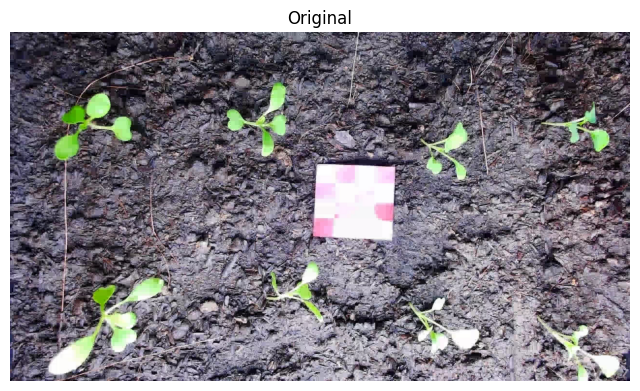

In [63]:
img = imread_any(Path(IMG_PATH))
if img is None:
    raise FileNotFoundError(f"อ่านภาพไม่สำเร็จ: {IMG_PATH}")
imshow("Original", img)

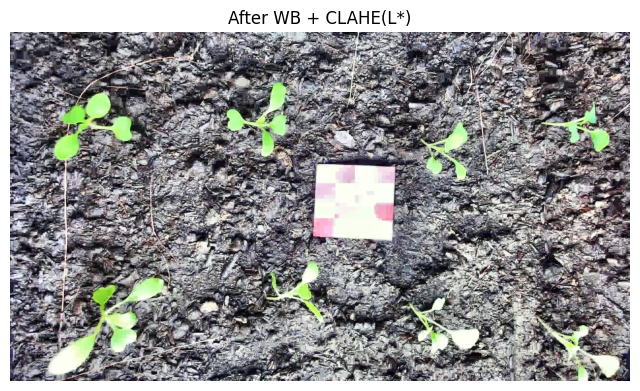

In [64]:
# White balance: gray-world
b,g,r = cv2.split(img.astype(np.float32))
avg = (b.mean()+g.mean()+r.mean())/3.0
b = np.clip(b*avg/(b.mean()+1e-6),0,255)
g = np.clip(g*avg/(g.mean()+1e-6),0,255)
r = np.clip(r*avg/(r.mean()+1e-6),0,255)
img_wb = cv2.merge([b,g,r]).astype(np.uint8)

# CLAHE ที่ L*
lab = cv2.cvtColor(img_wb, cv2.COLOR_BGR2Lab)
L,a,b2 = cv2.split(lab)
L = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(L)
img_eq = cv2.cvtColor(cv2.merge([L,a,b2]), cv2.COLOR_Lab2BGR)

imshow("After WB + CLAHE(L*)", img_eq)


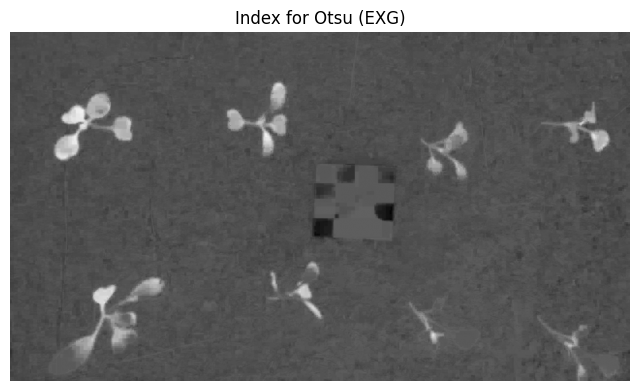

In [65]:
B,G,R = cv2.split(img_eq.astype(np.float32))

# ExG
exg = 2*G - R - B
exg_u8 = cv2.normalize(exg, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# VARI แบบมาตรฐาน: (G - R) / (G + R - B)
den = (G + R - B)
vari = (G - R) / (den + 1e-6)
vari = np.nan_to_num(vari, nan=0.0, posinf=0.0, neginf=0.0)
vari_u8 = cv2.normalize(vari, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

src = exg_u8 if INDEX_NAME.lower()=="exg" else vari_u8
imshow(f"Index for Otsu ({INDEX_NAME.upper()})", src)


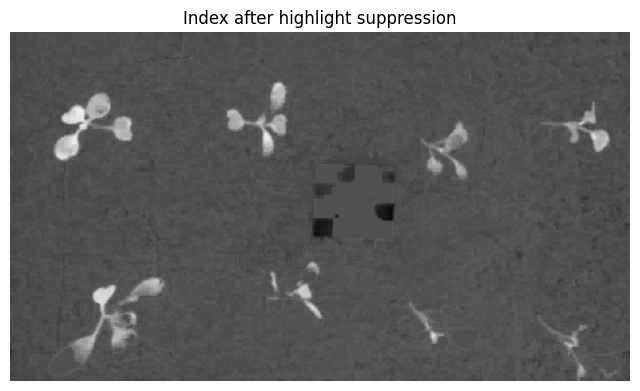

In [66]:
src_fix = src.copy()
if HANDLE_HIGHLIGHT:
    hsv = cv2.cvtColor(img_eq, cv2.COLOR_BGR2HSV)
    H,S,V = cv2.split(hsv)
    spec = (S < SPEC_S_MAX) & (V > SPEC_V_MIN)    # พิกเซลไฮไลต์
    # แทนค่าดัชนีบริเวณไฮไลต์ด้วยค่ามัธยฐานของส่วนที่ไม่ใช่ไฮไลต์
    median_val = np.median(src[~spec]) if np.any(~spec) else int(np.median(src))
    src_fix[spec] = median_val

imshow("Index after highlight suppression" if HANDLE_HIGHLIGHT else "Index (unchanged)", src_fix)


Thresholds: [ 78 105 156]


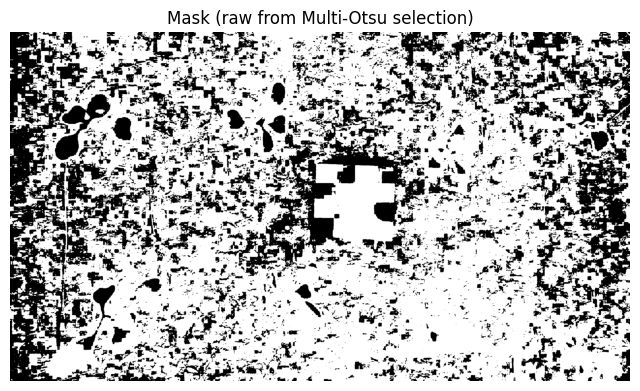

In [67]:
# Smooth ฮิสโตแกรมก่อน Otsu (ช่วยความนิ่ง)
src_s = cv2.GaussianBlur(src_fix, (0,0), SMOOTH_SIGMA) if SMOOTH_SIGMA>0 else src_fix

# Multi-Otsu
thresholds = threshold_multiotsu(src_s, classes=CLASSES)
regions = np.digitize(src_s, bins=thresholds)   # ค่าจะเป็น 0..CLASSES-1
print("Thresholds:", thresholds)

# เลือกคลาสพืช
hsv  = cv2.cvtColor(img_eq, cv2.COLOR_BGR2HSV)
H,S,V = cv2.split(hsv)
lab2 = cv2.cvtColor(img_eq, cv2.COLOR_BGR2Lab)
_,a2,_ = cv2.split(lab2)

if CLASSES==4 and MERGE_MIDDLE_IF_4:
    # รวมคลาสกลาง (ใบมืด/ใบสว่าง) เข้าด้วยกัน
    mask = ((regions==1) | (regions==2)).astype(np.uint8)*255
else:
    if AUTO_PICK_CLASS:
        cands = []
        for k in range(CLASSES):
            idx = (regions==k)
            if idx.sum()==0:
                cands.append((-1,-1,k)); continue
            hue_ok = H_RANGE[0] <= H[idx].mean() <= H_RANGE[1]
            sat_ok = S[idx].mean() >= S_MIN
            a_ok   = a2[idx].mean() <= A_MAX
            score  = int(hue_ok) + int(sat_ok) + int(a_ok)
            cands.append((score, idx.sum(), k))
        veg_k = sorted(cands, key=lambda t: (t[0], t[1]))[-1][2]
        mask = (regions==veg_k).astype(np.uint8)*255
    else:
        # ถ้าไม่ auto: เลือก bin สูงสุดเป็นพืช
        mask = (regions==(CLASSES-1)).astype(np.uint8)*255

imshow("Mask (raw from Multi-Otsu selection)", mask)


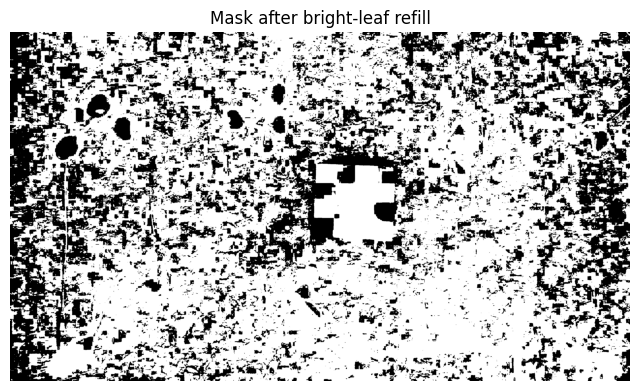

In [68]:
Hmin, Hmax = H_RANGE
refill = (mask==0) & (H>=Hmin) & (H<=Hmax) & (S>=S_MIN) & (V<=V_MAX) & (a2<=A_MAX)
mask2 = mask.copy()
mask2[refill] = 255
imshow("Mask after bright-leaf refill", mask2)


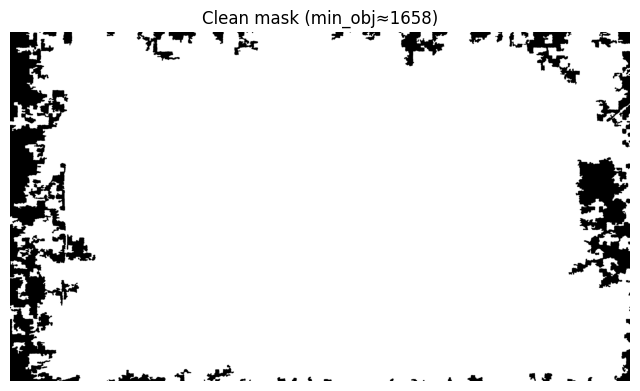

In [69]:
k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(OPEN_K), int(OPEN_K)))
k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(CLOSE_K), int(CLOSE_K)))

m = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, k_close)
m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  k_open)

MIN_OBJ = int(MIN_OBJ_RATIO * m.size)
cnts,_  = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
clean = np.zeros_like(m)
for c in cnts:
    if cv2.contourArea(c) >= MIN_OBJ:
        cv2.drawContours(clean, [c], -1, 255, cv2.FILLED)

imshow(f"Clean mask (min_obj≈{MIN_OBJ})", clean)


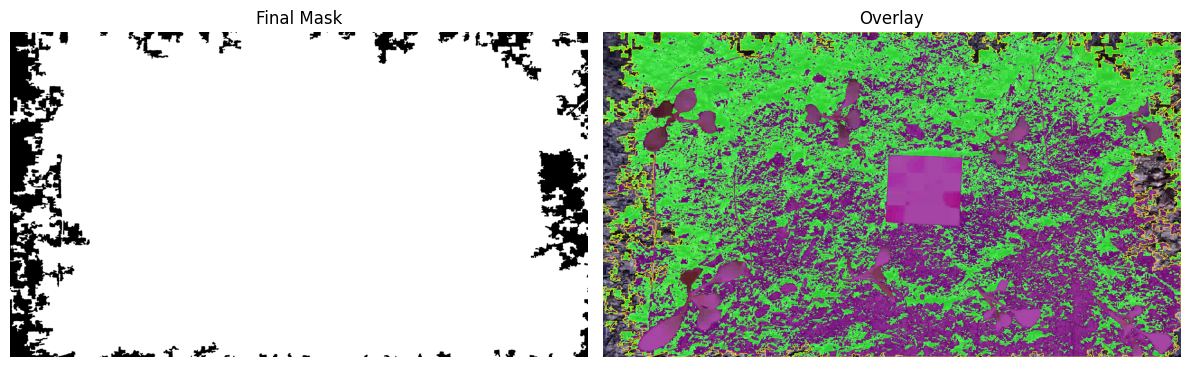

Vegetation pixels: 7530196  (90.79%)


In [70]:
overlay = img.copy()
overlay[clean>0] = (0.5*overlay[clean>0] + [40,200,40]).astype(np.uint8)
cnts,_ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay, cnts, -1, (0,255,255), 2)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(clean, cmap='gray'); plt.title("Final Mask"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Overlay"); plt.axis('off')
plt.tight_layout(); plt.show()

veg_px = int((clean>0).sum())
pct = 100.0 * veg_px / clean.size
print(f"Vegetation pixels: {veg_px}  ({pct:.2f}%)")
